In [1]:
import os

import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import configparser
import json


import modules.load_data as ld
from modules.modules_FIG_08_10_11 import *

config = configparser.ConfigParser()
config.read("ConfigFile.ini")
pf = config['PATHS']['datasets']

ECRAD = xr.open_dataset(os.path.join(pf,"TCARS.nc"))
# bias correction see FIG5 
ECRAD.REari_sfc.values = ECRAD.REari_sfc.values+1.5
ECRAD.REari_toa.values = ECRAD.REari_toa.values-0.6

stations= ld.dwd_stations()
stations = stations.where(stations.station!='ZG',drop=True)


models = np.array([
                   'MRM61',
                   'ESRA',
                   'Heliosat1I',
                   'SOLISsimple',
                   'CEM',
                   'MMAC',
                   'METSTAT',
                  ])


models_label = np.array([
                         'MRM v6.1',
                         'ESRA',
                         'Heliosat-1',
                         'Solis simple',
                         'CEM',
                         'MMAC',
                         'METSTAT',
 
                        ])

models_aodwvl = np.array([
                           550,
                           550,
                           550,
                           700,
                           0,
                           0,
                           0,
                          ])

fname_CAMS_AOD = os.path.join(pf,"TCARS_CSF_AOD_2015.nc")
dsAOD = xr.open_dataset(fname_CAMS_AOD)

fname_AERONET = os.path.join(pf,'aeronet_sites.json')
path_AERONET = os.path.join(pf,'AERONET/')

with open(fname_AERONET) as txt:
    sites=json.load(txt)  
    
Aaod_AOD_KEY = 'AOD_500nm'



In [2]:
import cartopy.crs as ccrs
def make_plot1(fig,ax,x,y,data,data2=None,title='',
              clabel='',cmap='autumn_r',cborientation='vertical',cbaxextend=[],
              cbpanchor=False,cbspacing='proportional',
              cb=True,cbarres=2,cbticks=None,cbaspect=20,
              data2res=2,data2ticks=None):
    # make subplot

    ax.set_title(title,fontsize=14)
    
    # plot map
    fig,ax = make_map(fig,ax)
   
    if type(cbticks)==type(None):
        # make contourplot
        ticks = np.arange(np.round(np.nanpercentile(data,1),cbarres)-10**(-cbarres),
                          np.round(np.nanpercentile(data,99),cbarres)+10**(-cbarres),10**(-cbarres))
        while len(ticks)>11:
            ticks = ticks[::2]
    else:
        ticks=cbticks
    p1=ax.contourf(x,y,data,transform=ccrs.PlateCarree(),cmap=cmap,vmin=np.min(ticks),vmax=np.max(ticks),
                   levels = ticks)
    
    if type(data2)!=type(None):
        if type(data2ticks)==type(None):
            # make contourplot
            ticks2 = np.arange(np.round(np.nanpercentile(data2,1),data2res),
                               np.round(np.nanpercentile(data2,99),data2res),10**(-data2res))
            while len(ticks2)>11:
                ticks2 = ticks2[::2]
        else:
            ticks2=data2ticks
        
        CS=ax.contour(x,y,data2,transform=ccrs.PlateCarree(),levels=ticks2,colors=['k']*len(ticks2))
        ax.clabel(CS, inline=1, fontsize=14)
    
    if cb:
        cbaxes = ax
        if len(cbaxextend)>0:
            cbaxes = [ax]+cbaxextend
        if type(cbpanchor)==type(bool):
            cb = plt.colorbar(p1,ax=cbaxes,ticks=ticks,
                              orientation=cborientation,
                              aspect=cbaspect,
                              spacing=cbspacing,pad=0.05,shrink=0.9,
                              label = ' ')
        else:
            cb = plt.colorbar(p1,ax=cbaxes,ticks=ticks,
                              orientation=cborientation,
                              panchor=cbpanchor,
                              aspect=cbaspect,
                              spacing=cbspacing,pad=0.05,shrink=0.9,
                              label = ' ')
        cb.ax.set_title(clabel,loc='left')
    fig.canvas.draw()
    return fig, ax

# Figs 11 and A4-A7
These figures show the annual and seasonal means of AOD, AE, SSA and ASY. The AOD panel shows the corresponding AOD observations or retrievals at AERONET and DWD stations. Note, that the CAMS RA AOD may deviate strongly from measurement data due to subgrid scale effects such as variing orographie. Even AERONET vs. DWD station observations from the same city may deviate strongly, as the individual stations location is different and may be influenced by polution by e.g. a close by street.

In [3]:
# annual mean
AODyear = dsAOD.sel(model='ESRA')
AODyear = AODyear.interpolate_na(dim='day')
AODyear = AODyear.assign({'latitude':('station',stations.latitude),
                          'longitude':('station',stations.longitude)})



Eseas = ECRAD.groupby('day.season').mean(skipna=True)
AODseas = AODyear.groupby('day.season').mean(skipna=True)

for seas in ['DJF','MAM','JJA','SON']:
    globals()[f"E{seas}"] = Eseas.sel(season=seas)
    globals()[f"AOD{seas}"] = AODseas.sel(season=seas)

Eyear = ECRAD.mean(dim='day',skipna=True)# where(~np.isnan(AODyear.CAOD.values))
AODyear = AODyear.mean(dim='day',skipna=True)


aodsyear,lons,lats=[],[],[]
for seas in ['DJF','MAM','JJA','SON']:
        globals()[f"aods{seas}"] = []
for site in sites.keys():  
    Aaod20,_ = ld.load_aeronet(site,pf=path_AERONET)
    if type(Aaod20)==bool:
        continue
    ds = xr.Dataset.from_dataframe(Aaod20).swap_dims({'index':'time'})
    try:
        aod = ds.AOD_500nm.sel(time='2015').resample(time='1D').mean(skipna=True)
        aod = aod.rename({'time':'day'}).reindex_like(AODyear).interpolate_na(dim='day')
        aodyear = aod.mean(skipna=True)
        aodseas = aod.groupby('day.season').mean(skipna=True)
        aodyear = float(aodyear)
        for seas in aodseas.season.values:
            globals()[f"aod{seas}"] = float(aodseas.sel(season=seas).values)
    except:
        continue
    lat = sites[site]['position']['latitude']
    lon = sites[site]['position']['longitude']

    aodsyear.append(aodyear)
    for seas in ['DJF','MAM','JJA','SON']:
        globals()[f"aods{seas}"].append(globals()[f"aod{seas}"])
    lats.append(lat)
    lons.append(lon)

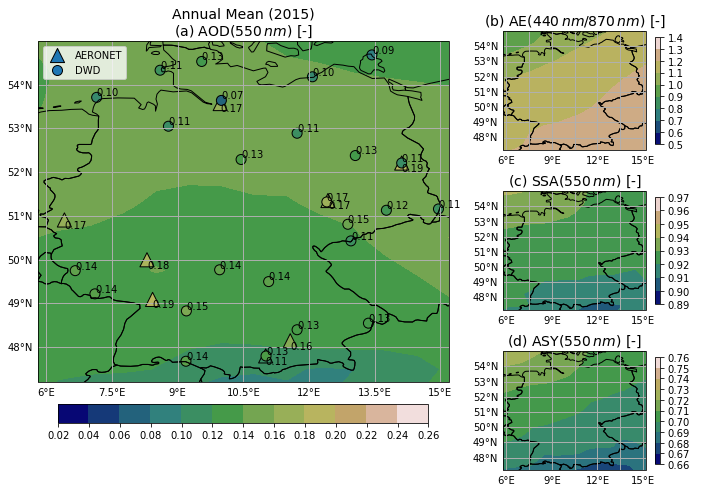

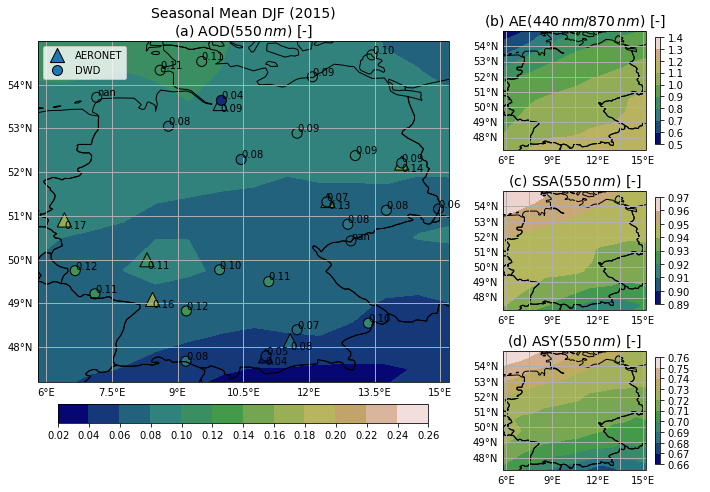

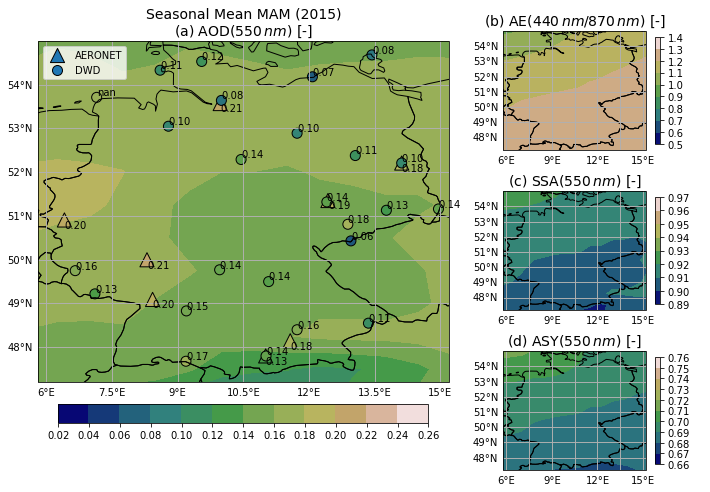

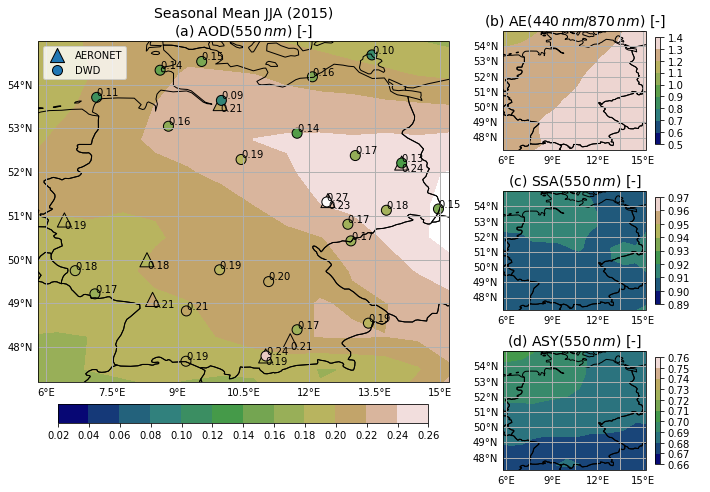

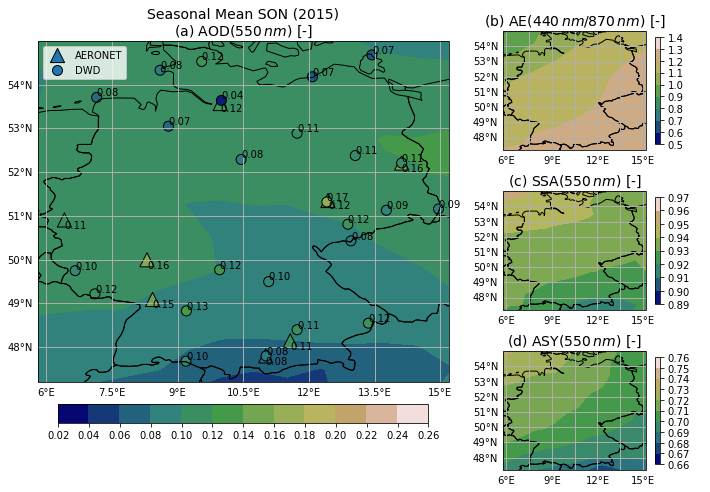

In [4]:
### plot Figures 11 and A4-A7


for select in ['year','DJF','MAM','JJA','SON']:
    E = globals()[f"E{select}"]
    AOD = globals()[f"AOD{select}"]
    aods = globals()[f"aods{select}"]

    ### aerosol situation

    fig = plt.figure(figsize=(10,7))
    vmin=0.02
    vmax=0.26

    ax = plt.subplot2grid((3,3),(0,0),
                          colspan=2,rowspan=3,
                          projection=ccrs.PlateCarree())
    
    if select == 'year':
        title = "Annual Mean (2015)"
    else:
        title = f"Seasonal Mean {select} (2015)"
    fig,ax = make_plot1(fig,ax,E.lon,E.lat,E.AOD.values,
                       cbpanchor=(0.5,-0.2),
                       cbticks=np.arange(vmin,vmax+0.02,0.02),
                       title=title+'\n'+r'(a) AOD(550$\,nm$) [-]',cmap='gist_earth',
                       cborientation='horizontal')
    ax.scatter(lons,lats,
               s = 200,
               c = aods,
               vmin=vmin,vmax=vmax,
               cmap='gist_earth',
               edgecolors = 'k',
               marker='^',
              transform=ccrs.PlateCarree(),label='AERONET')  

    ax.scatter(AOD.longitude,AOD.latitude,
               s = 100,
               c = AOD.CAOD.values,
               vmin=vmin,vmax=vmax,
               cmap='gist_earth',
               edgecolors = 'k',
              transform=ccrs.PlateCarree(), label='DWD')
    for station in stations.station.values:
        AODs = AOD.sel(station=station)
        aod = float(AODs.CAOD.values)
        lat = float(AODs.latitude.values)
        lon = float(AODs.longitude.values)
        ax.annotate(f"{aod:.2f}",
                    xy=(lon,lat),
                    va='bottom',
                    transform=ccrs.PlateCarree())

    for lat,lon,aod in zip(lats,lons,aods):
        ax.annotate(f"{aod:.2f}",
                    xy=(lon,lat),
                    va='top',
                    transform=ccrs.PlateCarree())

    plt.legend()

    ax = plt.subplot2grid((3,3),(0,2),
                          colspan=1,rowspan=1,
                          projection=ccrs.PlateCarree())
    fig,ax = make_plot1(fig,ax,E.lon,E.lat,E.AE.values,
                       title=r'(b) AE(440$\,nm$/870$\,nm$) [-]',cmap='gist_earth',cbarres=1,
                        cbticks=np.arange(0.5,1.5,0.1))

    ax = plt.subplot2grid((3,3),(1,2),
                          colspan=1,rowspan=1,
                          projection=ccrs.PlateCarree())
    fig,ax = make_plot1(fig,ax,E.lon,E.lat,E.SSA.values,
                        title=r'(c) SSA(550$\,nm$) [-]',cmap='gist_earth',
                        cbticks=np.arange(0.89,0.98,0.01))

    ax = plt.subplot2grid((3,3),(2,2),
                          colspan=1,rowspan=1,
                          projection=ccrs.PlateCarree())
    fig,ax = make_plot1(fig,ax,E.lon,E.lat,E.G.values,
                        title=r'(d) ASY(550$\,nm$) [-]',cmap='gist_earth',
                        cbticks=np.arange(0.66,0.77,0.01))
    plt.tight_layout()
    
    figname = "Figures/Fig{figno}.pdf"
    if select == 'year':
        figno = '11'
    elif select == 'DJF':
        figno = 'A4'
    elif select == 'MAM':
        figno = 'A5'
    elif select == 'JJA':
        figno = 'A6'
    elif select == 'SON':
        figno = 'A7'
    
    plt.savefig(figname.format(figno=figno),dpi=300,bbox_inches='tight')

---

## Fig14
Annual mean REari at the surface (SFC), TOA and total atmosphere (ATM) over Germany.

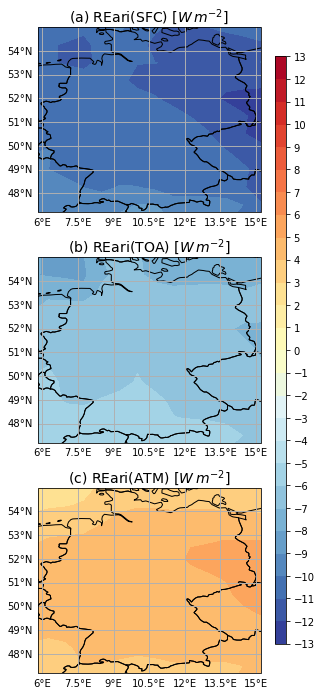

In [5]:
# annual mean
Eyear = ECRAD.mean(dim='day')

### REari overview
fig = plt.figure(figsize=(5,12))
ax = plt.subplot(311,projection=ccrs.PlateCarree())
fig,ax1 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.REari_sfc,cmap='RdYlBu_r',cb=False,
                   cbticks=np.arange(-13,14,1),
                   title=r'(a) REari(SFC) [$W\,m^{-2}$]')
ax = plt.subplot(312,projection=ccrs.PlateCarree())
fig,ax2 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.REari_toa,cmap='RdYlBu_r',
                   cb=False,
                   cbticks=np.arange(-13,14,1),
                   title=r'(b) REari(TOA) [$W\,m^{-2}$]')
ax = plt.subplot(313,projection=ccrs.PlateCarree())
fig,ax3 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.REari_toa-Eyear.REari_sfc,
                   cmap='RdYlBu_r',cbaxextend=[ax1,ax2],
#                     cborientation='horizontal',
                    cbpanchor=(0.4,0.5),
                     cbaspect=50,
                   cbticks=np.arange(-13,14,1),
                   title=r'(c) REari(ATM) [$W\,m^{-2}$]')
plt.savefig("Figures/Fig14.pdf",dpi=300,bbox_inches='tight')

---

## Fig 13 and A8

Annual radiation exposure calculated for GHI and DNI and the reduction by aerosol.

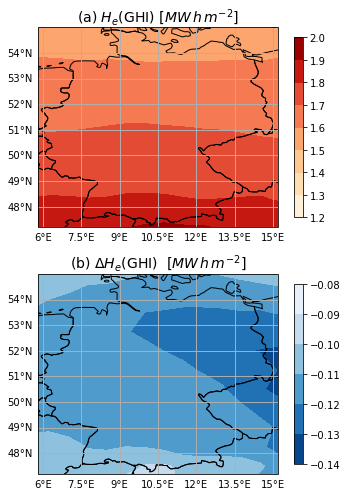

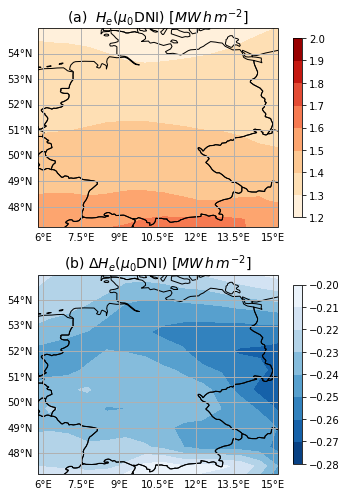

In [6]:
### plot Figurest 13 and A8
# annual mean
Eyear = ECRAD.mean(dim='day')

fig = plt.figure(figsize=(5,7))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
fig,ax1 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.GLO.values*24.*365*1e-6,cmap='OrRd',#
                   cbticks=np.arange(1.20,2.1,0.1),
                   title=r'(a) $H_e$(GHI) [$MW\,h\,m^{-2}$]')
ax = plt.subplot(212,projection=ccrs.PlateCarree())
fig,ax2 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,(Eyear.GLO-Eyear.GLO0).values*24.*365*1e-6,cmap='Blues_r',
                   cbticks=np.arange(-0.14,-0.08,0.01),
                   title=r'(b) ${\Delta}H_e$(GHI)  [$MW\,h\,m^{-2}$]')

plt.tight_layout()
plt.savefig("Figures/Fig13.pdf",dpi=300,bbox_inches='tight')

fig = plt.figure(figsize=(5,7))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
fig,ax3 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,Eyear.DIR.values*24.*365*1e-6,cmap='OrRd',
                     cbticks=np.arange(1.20,2.1,0.1),
                   title=r'(a)  $H_e$($\mu_0$DNI) [$MW\,h\,m^{-2}$]')
ax = plt.subplot(212,projection=ccrs.PlateCarree())
fig,ax4 = make_plot1(fig,ax,Eyear.lon,Eyear.lat,(Eyear.DIR-Eyear.DIR0).values*24.*365*1e-6,cmap='Blues_r',
                    cbticks=np.arange(-0.28,-0.20,0.01),
                   title=r'(b) ${\Delta}H_e$($\mu_0$DNI) [$MW\,h\,m^{-2}$]')

plt.tight_layout()
plt.savefig("Figures/FigA8.pdf",dpi=300,bbox_inches='tight')


